## Regular Laplacian

In [1]:
%%capture --no-display
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from scipy.stats import pearsonr
from scipy.linalg import lstsq
from sklearn.preprocessing import minmax_scale

# spectrome
from spectrome.brain import Brain
from spectrome.utils import functions, path
from spectrome.forward import eigenmode, laplacian

In [2]:
# house keeping here
plt.style.use('seaborn-paper')
data_dir ='../../data/'
hcp_dir = '../../data'

# Load Pablo's Yeo 2017 canonical network maps
com_dk = np.load(
    "../../data/com_dk.npy",
    allow_pickle = True
).item()
DK_df_normalized = pd.read_csv(
    "../../data/DK_dictionary_normalized.csv"
).set_index("Unnamed: 0")

### Get regular laplacian, no speed or frequency, and then obtain eigenmodes:

In [3]:
# create brain object
fc_brain = Brain.Brain()
fc_brain.add_connectome(hcp_dir)
fc_brain.reorder_connectome(fc_brain.connectome, fc_brain.distance_matrix)
fc_brain.bi_symmetric_c()
fc_brain.reduce_extreme_dir()

In [ ]:
# laplacian eigen decomposition math check:
C = fc_brain.reducedConnectome
nroi = fc_brain.reducedConnectome.shape[0]

rowdegree = np.transpose(np.sum(C, axis = 1))
coldegree = np.sum(C, axis = 0)
qind = rowdegree + coldegree < 0.2 * np.mean(rowdegree + coldegree)
rowdegree[qind] = np.inf
coldegree[qind] = np.inf

L1 = np.identity(nroi)
L2 = np.divide(1, np.sqrt(np.multiply(rowdegree, coldegree)) + np.spacing(1))

In [ ]:
L3 = np.matmul(np.diag(L2), C)

In [ ]:
a = 0.9
L = L1 - a*L3
d, v = np.linalg.eig(L)
eig_ind = np.argsort(d)
eig_ind

#### Check both eigen modes and eigen values

In [ ]:
# get regular laplacian eigenmodes:
fc_brain.add_regular_laplacian_eigenmodes(alpha = 1, num_ev = 86, vis = False)
fc_brain.norm_regular_eigenmodes[:,0]

In [ ]:
fc_brain.regular_eigenvalues

### find optimal alpha

In [ ]:
def search_alpha(fnetworks, fc_name):
    brain = Brain.Brain()
    brain.add_connectome(hcp_dir)
    brain.reorder_connectome(fc_brain.connectome, fc_brain.distance_matrix)
    brain.bi_symmetric_c()
    brain.reduce_extreme_dir()
    alpha_vec = np.linspace(1,5, 5)
    corr_vec = np.zeros(alpha_vec.shape)
    canon_network = np.squeeze(np.nan_to_num(fnetworks.loc[fc_name].values))
    for i in np.arange(0,len(alpha_vec)):
        brain.add_regular_laplacian_eigenmodes(alpha = alpha_vec[i], num_ev = 86, vis = False)
        eig_corrs = np.zeros(86)
        for e in np.arange(0, brain.norm_regular_eigenmodes.shape[1]):
            eig_corrs[e] = pearsonr(canon_network, brain.norm_regular_eigenmodes[:,e])[0]
            
        #alpha_vec[i] = np.mean(eig_corrs)
        alpha_vec[i] = np.amax(eig_corrs)
        print(eig_corrs)
        print(np.argmax(eig_corrs))
        
    highest_index = np.argmax(alpha_vec)
    best_alpha = alpha_vec[highest_index]
    return alpha_vec, best_alpha, eig_corrs

In [ ]:
alpha_vec, best_alpha, eig_corrs = search_alpha(DK_df_normalized, fc_name = 'Default')

In [ ]:
alpha_vec

In [ ]:
alpha_vec = np.linspace(1,5,5)
corr_vec = np.zeros(alpha_vec.shape)
canon_network = np.squeeze(np.nan_to_num(DK_df_normalized.loc['Default'].values))

# try alpha:
fc_brain.add_regular_laplacian_eigenmodes(alpha = alpha_vec[1], num_ev = 86, vis = False)
pearsonr(canon_network, fc_brain.norm_regular_eigenmodes[:,2])

In [ ]:
print(np.mean(fc_brain.norm_regular_eigenmodes, axis = 1))
print(fc_brain.norm_regular_eigenmodes[:,0])

In [ ]:
fc_brain.add_regular_laplacian_eigenmodes(alpha = alpha_vec[3], num_ev = 86, vis = False)
print(np.mean(fc_brain.norm_regular_eigenmodes, axis = 1))
print(fc_brain.norm_regular_eigenmodes[:,0])

### Calculate similarity:

For some reason, `numpy`'s linear least squares and `scipy`'s default linear least square settings have crashes due to SVD convergencem most likely caused by maximum iteration limits in c-compiled code. 

In [4]:
def compute_residual_corrs(fnetworks, fc_name, num_em = 86):
    brain = Brain.Brain()
    brain.add_connectome(hcp_dir)
    brain.reorder_connectome(fc_brain.connectome, fc_brain.distance_matrix)
    brain.bi_symmetric_c()
    brain.reduce_extreme_dir()
    brain.add_regular_laplacian_eigenmodes(alpha = 1, num_ev = num_em, vis = False)
    
    eig_corrs = np.zeros(num_em)
    canon_network = np.squeeze(np.nan_to_num(fnetworks.loc[fc_name].values))

    for e in np.arange(0, num_em):
        eig_corrs[e] = pearsonr(canon_network, brain.norm_regular_eigenmodes[:,e])[0]
    
    ordered_corr = np.argsort(-np.round(eig_corrs, 3))
    cumulative_res = np.zeros(num_em)
    cumulative_cor = np.zeros(num_em)
    
    #print(fc_name)
    for k in np.arange(0, num_em):
        selected_eigs = brain.norm_regular_eigenmodes[:,ordered_corr[0:k+1]]
        #print(selected_eigs.size)
        coef, _, _, _ = lstsq(selected_eigs, canon_network, lapack_driver = 'gelsy')
        #print(coef)
        #print(res)
        dp = (np.dot(selected_eigs, np.asarray(coef))**2)
        comp_res = np.sum(canon_network - dp)
        #print(dp)
        #print(np.sum(comp_res))
        comb_corr = np.matmul(selected_eigs, np.asarray(coef))
        comb_corr = np.squeeze(minmax_scale(comb_corr))
        #if res.size == 0:
        #    res = 0
        cumulative_res[k] = np.squeeze(np.asarray(comp_res))
        cumulative_cor[k] = pearsonr(np.squeeze(canon_network), comb_corr)[0]
    
    return cumulative_res, cumulative_cor

In [5]:
K = 58

canon_network = np.squeeze(np.nan_to_num(DK_df_normalized.loc['Frontoparietal'].values))
fc_brain.add_regular_laplacian_eigenmodes(alpha = 3, num_ev = K, vis = False)
eig_corrs = np.zeros(K)
for e in np.arange(0, K):
    eig_corrs[e] = pearsonr(canon_network, fc_brain.norm_regular_eigenmodes[:,e])[0]
        
ordered_corr = np.argsort(-np.round(eig_corrs,3))
#print(ordered_corr)
for k in np.arange(0, K):
    selected_eigs = fc_brain.norm_regular_eigenmodes[:,ordered_corr[0:k+1]]
    if k == 56:
        #print(selected_eigs)
    coef, res, _, _ = lstsq(selected_eigs, canon_network, lapack_driver = 'gelsy')

#print(coef)
#print(res)

IndentationError: expected an indented block (<ipython-input-5-6675cfaa8f7c>, line 15)

In [5]:
reg_res = np.zeros([86,7])
reg_cor = np.zeros([86,7])

reg_res[:,1], reg_cor[:,1] = compute_residual_corrs(DK_df_normalized, 'Default')

reg_res[:,3], reg_cor[:,3] = compute_residual_corrs(DK_df_normalized, 'Frontoparietal')

reg_res[:,5], reg_cor[:,5] = compute_residual_corrs(DK_df_normalized, 'Dorsal_Attention')

reg_res[:,0], reg_cor[:,0] = compute_residual_corrs(DK_df_normalized, 'Limbic')

reg_res[:,4], reg_cor[:,4] = compute_residual_corrs(DK_df_normalized, 'Somatomotor')

reg_res[:,6], reg_cor[:,6] = compute_residual_corrs(DK_df_normalized, 'Ventral_Attention')

reg_res[:,2], reg_cor[:,2] = compute_residual_corrs(DK_df_normalized, 'Visual')

#### Load optimal results for complex laplacian:

In [6]:
r2s = np.zeros([7,10])

h5_path = path.get_file_path('laplacian_networks/Default9_BH_corr.h5')
bh_default = path.read_hdf5(h5_path)
r2s[0,:] = [bh_default['LinRegResults'][i]['r2score'] for i in range(len(bh_default['LinRegResults']))]

h5_path = path.get_file_path('laplacian_networks/Dorsal_Attention4_BH_corr.h5')
bh_dorsal = path.read_hdf5(h5_path)
r2s[1,:] = [bh_dorsal['LinRegResults'][i]['r2score'] for i in range(len(bh_dorsal['LinRegResults']))]

h5_path = path.get_file_path('laplacian_networks/Frontoparietal6_BH_corr.h5')
bh_front = path.read_hdf5(h5_path)
r2s[2,:] = [bh_front['LinRegResults'][i]['r2score'] for i in range(len(bh_front['LinRegResults']))]

h5_path = path.get_file_path('laplacian_networks/Limbic9_BH_corr.h5')
bh_limbic = path.read_hdf5(h5_path)
r2s[3,:] = [bh_limbic['LinRegResults'][i]['r2score'] for i in range(len(bh_limbic['LinRegResults']))]

h5_path = path.get_file_path('laplacian_networks/Somatomotor6_BH_corr.h5')
bh_motor = path.read_hdf5(h5_path)
r2s[4,:] = [bh_motor['LinRegResults'][i]['r2score'] for i in range(len(bh_motor['LinRegResults']))]

h5_path = path.get_file_path('laplacian_networks/Ventral_Attention8_BH_corr.h5')
bh_ventral = path.read_hdf5(h5_path)
r2s[5,:] = [bh_ventral['LinRegResults'][i]['r2score'] for i in range(len(bh_ventral['LinRegResults']))]

h5_path = path.get_file_path('laplacian_networks/Visual2_BH_corr.h5')
bh_visual = path.read_hdf5(h5_path)
r2s[6,:] = [bh_visual['LinRegResults'][i]['r2score'] for i in range(len(bh_visual['LinRegResults']))]

function for computing correlation and residuals

In [7]:
def compute_linreg_scores(brain, fnetworks, f, a, s, fc_name, num_em):
    w = 2*np.pi*f
    # for complex laplacian:
    brain.add_laplacian_eigenmodes(w = w, alpha = a, speed = s, vis = False)
    canon_network = np.nan_to_num(fnetworks.loc[fc_name].values)
    corrs = np.squeeze(np.zeros([brain.norm_eigenmodes.shape[1],1]))
    for e in np.arange(0, len(corrs)):
        prcorr = pearsonr(np.squeeze(canon_network), brain.norm_eigenmodes[:,e])[0]
        corrs[e] = prcorr

    ntw_opt_corr = np.round(corrs,3)
    ordered_corr = np.argsort(-ntw_opt_corr)
    #assert ntw_opt_dice[ordered_dice[1]] > ntw_opt_dice[ordered_dice[0]]

    cumulative_regr = np.zeros([num_em,1])
    cumulative_corr = np.zeros([num_em,1])

    # for each eigenmode, compute:
    for k in np.arange(0, num_em):
        selected_eigs = brain.norm_eigenmodes[:,ordered_corr[0:k+1]]
        coef, _, _, _ = lstsq(selected_eigs, canon_network, lapack_driver = 'gelsy')

        comb_corr = np.squeeze(np.matmul(selected_eigs, np.asarray(coef)))
        dp = (np.dot(selected_eigs, np.asarray(coef))**2)
        residual = np.sum(canon_network - dp)
        
        cumulative_corr[k] = pearsonr(np.squeeze(canon_network), comb_corr)[0]
        cumulative_regr[k] = residual
    return np.squeeze(cumulative_regr), np.squeeze(cumulative_corr)


In [8]:
warnings.filterwarnings('ignore')

K = 30

comp_brain = Brain.Brain()
comp_brain.add_connectome(hcp_dir)
comp_brain.reorder_connectome(comp_brain.connectome, comp_brain.distance_matrix)
comp_brain.bi_symmetric_c()
comp_brain.reduce_extreme_dir()

regr_all = np.zeros([K,7]) 
corr_all = np.zeros([K,7])
regr_all[:,0], corr_all[:,0] = compute_linreg_scores(comp_brain, DK_df_normalized, f = bh_limbic['x'][0], a = bh_limbic['x'][1], 
                                           s = bh_limbic['x'][2], fc_name = 'Limbic', num_em = K)

regr_all[:,1], corr_all[:,1] = compute_linreg_scores(comp_brain, DK_df_normalized, f = bh_default['x'][0], a = bh_default['x'][1], 
                                           s = bh_default['x'][2], fc_name = 'Default', num_em = K)

regr_all[:,2], corr_all[:,2] = compute_linreg_scores(comp_brain, DK_df_normalized, f = bh_visual['x'][0], a = bh_visual['x'][1], 
                                           s = bh_visual['x'][2], fc_name = 'Visual', num_em = K)

regr_all[:,3], corr_all[:,3] = compute_linreg_scores(comp_brain, DK_df_normalized, f = bh_front['x'][0], a = bh_front['x'][1], 
                                           s = bh_front['x'][2], fc_name = 'Frontoparietal', num_em = K)

regr_all[:,4], corr_all[:,4] = compute_linreg_scores(comp_brain, DK_df_normalized, f = bh_motor['x'][0], a = bh_motor['x'][1], 
                                           s = bh_motor['x'][2], fc_name = 'Somatomotor', num_em = K)

regr_all[:,5], corr_all[:,5] = compute_linreg_scores(comp_brain, DK_df_normalized, f = bh_dorsal['x'][0], a = bh_dorsal['x'][1], 
                                           s = bh_dorsal['x'][2], fc_name = 'Dorsal_Attention', num_em = K)

regr_all[:,6], corr_all[:,6] = compute_linreg_scores(comp_brain, DK_df_normalized, f = bh_ventral['x'][0], a = bh_ventral['x'][1], 
                                           s = bh_ventral['x'][2], fc_name = 'Ventral_Attention', num_em = K)



### Random connectome based on distance:

In [10]:
from rajutils.utils import generate

C = generate.exp_neg_dist_Cij(fc_brain.distance_matrix)
print(C.shape)

(86, 86)


In [44]:
rd_brain = Brain.Brain()
rd_brain.add_connectome(hcp_dir)
rd_brain.reorder_connectome(rd_brain.connectome, rd_brain.distance_matrix)
rd_brain.bi_symmetric_c()
rd_brain.reduce_extreme_dir()
rd_brain.reducedConnectome = C

rng_runs = 1000

dft_rdnr = np.zeros([K,rng_runs]) 
dft_rdnc = np.zeros([K,rng_runs])

limbic_rdnr = np.zeros([K,rng_runs]) 
limbic_rdnc = np.zeros([K,rng_runs])

visual_rdnr = np.zeros([K,rng_runs]) 
visual_rdnc = np.zeros([K,rng_runs])

front_rdnr = np.zeros([K,rng_runs]) 
front_rdnc = np.zeros([K,rng_runs])

motor_rdnr = np.zeros([K,rng_runs]) 
motor_rdnc = np.zeros([K,rng_runs])

ventral_rdnr = np.zeros([K,rng_runs]) 
ventral_rdnc = np.zeros([K,rng_runs])

dorsal_rdnr = np.zeros([K,rng_runs]) 
dorsal_rdnc = np.zeros([K,rng_runs])

for n in np.arange(0, rng_runs):
    C = generate.exp_neg_dist_Cij(fc_brain.distance_matrix)
    rd_brain.reducedConnectome = C
    limbic_rdnr[:,n], limbic_rdnc[:,n] = compute_linreg_scores(rd_brain, DK_df_normalized, f = bh_limbic['x'][0], a = bh_limbic['x'][1], 
                                           s = bh_limbic['x'][2], fc_name = 'Limbic', num_em = K)

    dft_rdnr[:,n], dft_rdnc[:,n] = compute_linreg_scores(rd_brain, DK_df_normalized, f = bh_default['x'][0], a = bh_default['x'][1], 
                                           s = bh_default['x'][2], fc_name = 'Default', num_em = K)

    visual_rdnr[:,n], visual_rdnc[:,n] = compute_linreg_scores(rd_brain, DK_df_normalized, f = bh_visual['x'][0], a = bh_visual['x'][1], 
                                           s = bh_visual['x'][2], fc_name = 'Visual', num_em = K)

    front_rdnr[:,n], front_rdnc[:,n] = compute_linreg_scores(rd_brain, DK_df_normalized, f = bh_front['x'][0], a = bh_front['x'][1], 
                                           s = bh_front['x'][2], fc_name = 'Frontoparietal', num_em = K)

    motor_rdnr[:,n], motor_rdnc[:,n] = compute_linreg_scores(rd_brain, DK_df_normalized, f = bh_motor['x'][0], a = bh_motor['x'][1], 
                                           s = bh_motor['x'][2], fc_name = 'Somatomotor', num_em = K)

    dorsal_rdnr[:,n], dorsal_rdnc[:,n] = compute_linreg_scores(rd_brain, DK_df_normalized, f = bh_dorsal['x'][0], a = bh_dorsal['x'][1], 
                                           s = bh_dorsal['x'][2], fc_name = 'Dorsal_Attention', num_em = K)

    ventral_rdnr[:,n], ventral_rdnc[:,n] = compute_linreg_scores(rd_brain, DK_df_normalized, f = bh_ventral['x'][0], a = bh_ventral['x'][1], 
                                           s = bh_ventral['x'][2], fc_name = 'Ventral_Attention', num_em = K)


In [45]:
#save the intermediate results:
np.savez('data/distance_connectome_30eigs_rr.npz', limbic_regr = limbic_rdnr, limbic_corr = limbic_rdnc,
        default_regr = dft_rdnr, default_corr = dft_rdnc,
        visual_regr = visual_rdnr, visual_corr = visual_rdnc,
        front_regr = front_rdnr, front_corr = front_rdnc,
        motor_regr = motor_rdnr, motor_corr = motor_rdnc,
        dorsal_regr = dorsal_rdnr, dorsal_corr = dorsal_rdnc,
        ventral_regr = ventral_rdnr, ventral_corr = ventral_rdnc)

In [9]:
# load the npz file:
cdist = np.load('data/distance_connectome_30eigs_rr.npz')

In [10]:
cdist['front_regr'].shape

(30, 1000)

#### Compute 95% confidence interval for error bars:

In [18]:
in_data = cdist['front_corr']
ss = cdist['front_corr'].shape[1]
neig = cdist['front_corr'].shape[0]

z = np.arctanh(in_data[0,:])
SDz = np.std(z)
cfstat = 1.96*SDz

upper = np.tanh(z + cfstat)
lower = np.tanh(z - cfstat)

In [11]:
import scipy.stats

def get_zscore(in_data):
    sample_size = in_data.shape[1]
    num_eig = in_data.shape[0]
    confint = np.zeros([2,num_eig])
    r2z_values = np.zeros([num_eig, sample_size])
    
    for eig in np.arange(0,num_eig):
        z = np.arctanh(in_data[eig,:])
        SDz = np.std(z)
        cfstat = scipy.stats.norm.ppf(0.95)*SDz
        confint[0,eig] = np.mean(in_data[eig,:]) - np.tanh(np.mean(in_data[eig,:])-cfstat) #lower
        confint[1,eig] = np.tanh(np.mean(in_data[eig,:])+cfstat) - np.mean(in_data[eig,:]) #upper
        r2z_values[eig,:] = z
        #confint[0,eig] = np.tanh(np.mean(in_data[eig,:])-cfstat)-np.mean(in_data[eig,:]) #lower
        #confint[1,eig] = np.tanh(np.mean(in_data[eig,:])+cfstat)-np.mean(in_data[eig,:]) #upper
    return confint, r2z_values

def get_errorbar(in_data):
    n = len(in_data)
    xbar = np.mean(in_data)
    s = np.std(in_data)
    z = 1.96
    
    confint = np.zeros([2, n])
    confint[0,:] = xbar - (xbar - (z * (s/np.sqrt(n))))
    confint[1,:] = (xbar + (z * (s/np.sqrt(n)))) - xbar
    
    return confint

In [12]:
#from scipy.stats import norm
cf = 0.95

#llimbic:
limbic_fisher_int, r2z_limbic = get_zscore(cdist['limbic_corr'])
limbic_cfint = get_errorbar(cdist['limbic_corr'])

# default:
default_fisher_int, r2z_default = get_zscore(cdist['default_corr'])
default_cfint = get_errorbar(cdist['default_corr'])

# visual:
visual_fisher_int, r2z_visual = get_zscore(cdist['visual_corr'])
visual_cfint = get_errorbar(cdist['visual_corr'])

# frontalparietal:
front_fisher_int, r2z_front = get_zscore(cdist['front_corr'])
front_cfint = get_errorbar(cdist['front_corr'])

# somatomotor:
motor_fisher_int, r2z_motor = get_zscore(cdist['motor_corr'])
motor_cfint = get_errorbar(cdist['motor_corr'])

# dorsal attention:
dorsal_fisher_int, r2z_dorsal = get_zscore(cdist['dorsal_corr'])
dorsal_cfint = get_errorbar(cdist['dorsal_corr'])

# ventral attention:
ventral_fisher_int, r2z_ventral = get_zscore(cdist['ventral_corr'])
ventral_cfint = get_errorbar(cdist['ventral_corr'])

#### Convert to z-scores and do statistics:

### Make figure:

NameError: name 'regr_rd' is not defined

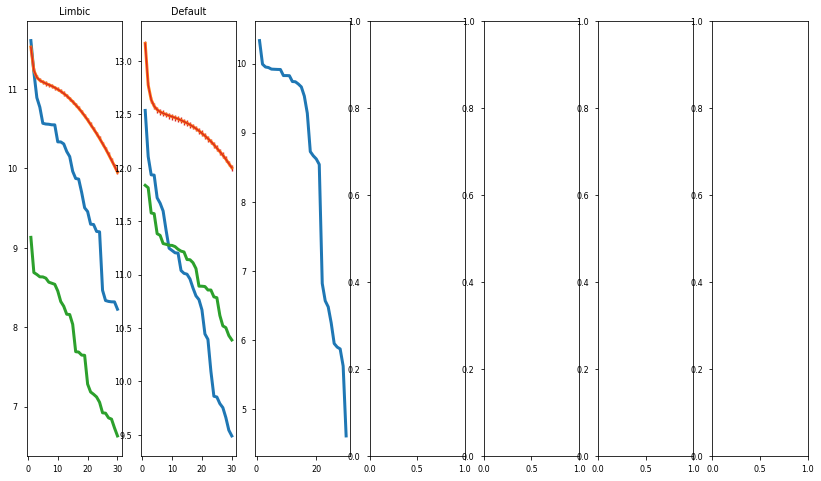

In [14]:
from cycler import cycler

custom_cycler = (cycler(color = ['blue','orange','purple','olive',
                          'sienna','black','darkslategray']))
x = np.arange(1,K+1)
ntwk_names = ['Limbic','Default','Visual','Frontoparietal','Somatomotor','Ventral Attention','Dorsal Attention']

with plt.style.context('seaborn-paper'):
    limbic_rmean = np.mean(cdist['limbic_regr'], axis = 1)
    fig, (m1,m2,m3,m4,m5,m6,m7) = plt.subplots(ncols = 7, figsize = [14, 8])
    m1.plot(x, reg_res[0:K,0], linewidth = 3)
    m1.plot(x, limbic_rmean, linewidth = 3)
    m1.plot(x, regr_all[0:K,0], linewidth = 3)
    m1.xaxis.set_major_locator(plt.MultipleLocator(10))
    #m1.set_xticklabels([0,1,25,50,75])
    m1.title.set_text(ntwk_names[0])
    m1.errorbar(x, limbic_rmean, yerr = limbic_cfint)
    
    default_rmean = np.mean(cdist['default_regr'], axis = 1)
    m2.plot(x, reg_res[0:K,1], linewidth = 3)
    m2.plot(x, default_rmean, linewidth = 3)
    m2.plot(x, regr_all[0:K,1], linewidth = 3)
    m2.xaxis.set_major_locator(plt.MultipleLocator(10))
    #m2.set_xticklabels([0,1,25,50,75])
    m2.errorbar(x, default_rmean, yerr = default_cfint)
    m2.title.set_text(ntwk_names[1])
    
    m3.plot(x, reg_res[0:K,2], linewidth = 3)
    m3.plot(x, regr_rd[0:K,2], linewidth = 3)
    m3.plot(x, regr_all[0:K,2], linewidth = 3)
    m3.xaxis.set_major_locator(plt.MultipleLocator(10))
    #m3.set_xticklabels([0,1,25,50,75])
    m3.title.set_text(ntwk_names[2])
    
    m4.plot(x, reg_res[0:K,3], linewidth = 3)
    m4.plot(x, regr_rd[0:K,3], linewidth = 3)
    m4.plot(x, regr_all[0:K,3], linewidth = 3)
    m4.xaxis.set_major_locator(plt.MultipleLocator(10))
    #m4.set_xticklabels([0,1,25,50,75])
    m4.title.set_text(ntwk_names[3])
    
    m5.plot(x, reg_res[0:K,4], linewidth = 3)
    m5.plot(x, regr_rd[0:K,4], linewidth = 3)
    m5.plot(x, regr_all[0:K,4], linewidth = 3)
    m5.xaxis.set_major_locator(plt.MultipleLocator(10))
    #m5.set_xticklabels([0,1,25,50,75])
    m5.title.set_text(ntwk_names[4])
    
    m6.plot(x, reg_res[0:K,5], linewidth = 3)
    m6.plot(x, regr_rd[0:K,5], linewidth = 3)
    m6.plot(x, regr_all[0:K,5], linewidth = 3)
    m6.xaxis.set_major_locator(plt.MultipleLocator(10))
    #m6.set_xticklabels([0,1,25,50,75])
    m6.title.set_text(ntwk_names[5])
    
    m7.plot(x, reg_res[0:K,6], linewidth = 3)
    m7.plot(x, regr_rd[0:K,6], linewidth = 3)
    m7.plot(x, regr_all[0:K,6], linewidth = 3)
    m7.xaxis.set_major_locator(plt.MultipleLocator(10))
    #m7.set_xticklabels([0,1,25,50,75])
    m7.title.set_text(ntwk_names[6])
    
    plt.legend(['Regular Laplacian', r'$C_{dist}$', 'Complex Laplacian'],
              loc = 'center left', bbox_to_anchor = (1, 0.5))
    
    fig.add_subplot(1,1,1, frameon = False)
    plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    plt.grid(False)
    plt.ylabel('Residual', fontsize = 13)
    plt.xlabel('Eigenmode Number', fontsize = 13)


In [ ]:
import string
LW = 4

with plt.style.context('seaborn-paper'):
    limbic_cmean = np.mean(cdist['limbic_corr'], axis = 1)
    fig, (i1,i2,i3,i4,i5,i6,i7) = plt.subplots(ncols = 7, figsize = [12, 7], sharey = True)
    i1.plot(x, corr_all[0:K,0], color = 'orange', linewidth = LW)
    i1.plot(x, reg_cor[0:K,0], color = 'blue', linewidth = LW)
    i1.plot(x, limbic_cmean, color = 'green', linewidth = LW)
    i1.fill_between(x, limbic_cmean - limbic_fisher_int[0,:], limbic_cmean + limbic_fisher_int[1,:],
                    color = 'darkslategray', alpha = 0.3)
    i1.xaxis.set_major_locator(plt.MultipleLocator(10))
    #i1.set_xticklabels([0,1,25,50,75])
    i1.title.set_text(ntwk_names[0])
    
    default_rmean = np.mean(cdist['default_corr'], axis = 1)
    i2.plot(x, corr_all[0:K,1], color = 'orange', linewidth = LW)
    i2.plot(x, reg_cor[0:K,1], color = 'blue', linewidth = LW)
    i2.plot(x, default_rmean, color = 'green', linewidth = LW)
    i2.fill_between(x, default_rmean - default_fisher_int[0,:], default_rmean + default_fisher_int[1,:],
                   color = 'darkslategray', alpha = 0.3)
    i2.xaxis.set_major_locator(plt.MultipleLocator(10))
    #i2.set_xticklabels([0,1,25,50,75])
    i2.title.set_text(ntwk_names[1])
    
    visual_rmean = np.mean(cdist['visual_corr'], axis = 1)
    i3.plot(x, corr_all[0:K,2], color = 'orange', linewidth = LW)
    i3.plot(x, reg_cor[0:K,2], color = 'blue', linewidth = LW)
    i3.plot(x, visual_rmean, color = 'green', linewidth = LW)
    i3.fill_between(x, visual_rmean - visual_fisher_int[0,:], visual_rmean + visual_fisher_int[1,:],
                    color = 'darkslategray', alpha = 0.3)
    i3.xaxis.set_major_locator(plt.MultipleLocator(10))
    #i3.set_xticklabels([0,1,25,50,75])
    i3.title.set_text(ntwk_names[2])
    
    front_rmean = np.mean(cdist['front_corr'], axis = 1)
    i4.plot(x, corr_all[0:K,3], color = 'orange', linewidth = LW)
    i4.plot(x, reg_cor[0:K,3], color = 'blue', linewidth = LW)
    i4.plot(x, front_rmean, color = 'green', linewidth = LW)
    i4.xaxis.set_major_locator(plt.MultipleLocator(10))
    i4.fill_between(x, visual_rmean - visual_fisher_int[0,:], visual_rmean + visual_fisher_int[1,:],
                   color = 'darkslategray', alpha = 0.3)
    #i4.set_xticklabels([0,1,25,50,75])
    i4.title.set_text(ntwk_names[3])
    
    motor_rmean = np.mean(cdist['motor_corr'], axis = 1)
    i5.plot(x, corr_all[0:K,4], color = 'orange', linewidth = LW)
    i5.plot(x, reg_cor[0:K,4], color = 'blue', linewidth = LW)
    i5.plot(x, motor_rmean, color = 'green', linewidth = LW)
    i5.fill_between(x, motor_rmean - motor_fisher_int[0,:], motor_rmean + motor_fisher_int[1,:],
               color = 'darkslategray', alpha = 0.3)
    i5.xaxis.set_major_locator(plt.MultipleLocator(10))
    #i5.set_xticklabels([0,1,25,50,75])
    i5.title.set_text(ntwk_names[4])
    
    dorsal_rmean = np.mean(cdist['dorsal_corr'], axis = 1)
    i6.plot(x, corr_all[0:K,5], color = 'orange', linewidth = LW)
    i6.plot(x, reg_cor[0:K,5], color = 'blue', linewidth = LW)
    i6.plot(x, dorsal_rmean, color = 'green', linewidth = LW)
    i6.fill_between(x, dorsal_rmean - dorsal_fisher_int[0,:], dorsal_rmean + dorsal_fisher_int[1,:],
               color = 'darkslategray', alpha = 0.3)
    i6.xaxis.set_major_locator(plt.MultipleLocator(10))
    #i6.set_xticklabels([0,1,25,50,75])
    i6.title.set_text(ntwk_names[5])
    
    ventral_rmean = np.mean(cdist['ventral_corr'], axis = 1)
    i7.plot(x, corr_all[0:K,6], color = 'orange', linewidth = LW)
    i7.plot(x, reg_cor[0:K,6], color = 'blue',linewidth = LW)
    i7.plot(x, ventral_rmean,color = 'green', linewidth = LW)
    i7.fill_between(x, ventral_rmean - ventral_fisher_int[0,:], ventral_rmean + ventral_fisher_int[1,:],
               color = 'darkslategray', alpha = 0.3)
    i7.xaxis.set_major_locator(plt.MultipleLocator(10))
    #i7.set_xticklabels([0,1,25,50,75])
    i7.title.set_text(ntwk_names[6])
    
    plt.legend(['Complex Laplacian', 'Real Laplacian', 'Random Laplacian'],
              loc = 'center left', bbox_to_anchor = (1, 0.5))
    
    fig.add_subplot(1,1,1, frameon = False)
    plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    plt.grid(False)
    plt.ylabel(string.capwords("Pearson's Correlation"), fontsize = 13)
    plt.xlabel('Eigenmode Number', fontsize = 13)

    plt.savefig('figures/fig6/pearsonr.png', dpi = 300, bbox_inches = 'tight')

### Create null distribution and compare.

For each of the 7 canonical networks, obtain P-values for each of the eigenmodes shown in figure.

In [27]:
from statsmodels.stats.multitest import multipletests

def null_distribution_pvalue(nulldist, reg_lap, com_lap):
    K = nulldist.shape[0]
    r_pval = np.zeros(K)
    c_pval = np.zeros(K)
    for i in np.arange(0,K):
        #print(i)
        z_dist = nulldist[i,:]
        r = reg_lap[i]
        c = com_lap[i]
        gkde = scipy.stats.gaussian_kde(dataset = z_dist)
        r_pval[i] = gkde.integrate_box_1d(r,1)
        c_pval[i] = gkde.integrate_box_1d(c,1)
        #print(r_pval)
        #print(c_pval[i])
    
    #_,adjusted_rp,_,bfc_ralpha = multipletests(r_pval)
    #_,adjusted_cp,_,bfc_calpha = multipletests(c_pval)
    return r_pval, c_pval #adjusted_rp, adjusted_cp

In [28]:
# computing bonferroni corrected p-values
reg_pvals = np.zeros([7, K])
com_pvals = np.zeros([7, K])

# limbic
reg_z = np.arctanh(reg_cor[0:K,0])
com_z = np.arctanh(corr_all[0:K,0])
reg_pvals[0,:], com_pvals[0,:] = null_distribution_pvalue(r2z_limbic, reg_z, com_z)

#default
reg_z = np.arctanh(reg_cor[0:K,1])
com_z = np.arctanh(corr_all[0:K,1])
reg_pvals[1,:], com_pvals[1,:] = null_distribution_pvalue(r2z_default, reg_z, com_z)

# visual
reg_z = np.arctanh(reg_cor[0:K,2])
com_z = np.arctanh(corr_all[0:K,2])
reg_pvals[2,:], com_pvals[2,:] = null_distribution_pvalue(r2z_visual, reg_z, com_z)

# frontoparietal
reg_z = np.arctanh(reg_cor[0:K,3])
com_z = np.arctanh(corr_all[0:K,3])
reg_pvals[3,:], com_pvals[3,:] = null_distribution_pvalue(r2z_front, reg_z, com_z)

# somatomotor
reg_z = np.arctanh(reg_cor[0:K,4])
com_z = np.arctanh(corr_all[0:K,4])
reg_pvals[4,:], com_pvals[4,:] = null_distribution_pvalue(r2z_motor, reg_z, com_z)

# dorsal
reg_z = np.arctanh(reg_cor[0:K,5])
com_z = np.arctanh(corr_all[0:K,5])
reg_pvals[5,:], com_pvals[5,:] = null_distribution_pvalue(r2z_dorsal, reg_z, com_z)

# ventral
reg_z = np.arctanh(reg_cor[0:K,6])
com_z = np.arctanh(corr_all[0:K,6])
reg_pvals[6,:], com_pvals[6,:] = null_distribution_pvalue(r2z_ventral, reg_z, com_z)

In [29]:
reg_pvals[:,0]

array([0.4746279 , 0.01239344, 0.00814814, 0.01282516, 0.00142533,
       0.07982844, 0.00454975])

In [30]:
com_pvals[:,0]

array([1.57173375e-08, 5.98038230e-04, 0.00000000e+00, 1.11022302e-19,
       1.11659306e-03, 3.91999766e-14, 1.46626449e-02])

#### Best eigenmode p-value:

In [33]:
_,adjusted_cp,_,bfc_calpha = multipletests(com_pvals[:,0])
print(adjusted_cp)
print(bfc_calpha)

[6.28693487e-08 1.79304196e-03 0.00000000e+00 0.00000000e+00
 2.23193933e-03 1.95954364e-13 1.46626449e-02]
0.0071428571428571435


In [34]:
_,adjusted_rp,_,bfc_ralpha = multipletests(reg_pvals[:,0])
print(adjusted_rp)
print(bfc_ralpha)

[0.4746279  0.04865975 0.04008216 0.04865975 0.00993478 0.1532843
 0.02698986]
0.0071428571428571435


#### Top 10 combined p-values:

In [35]:
_,adjusted_cp,_,bfc_calpha = multipletests(com_pvals[:,9])
print(adjusted_cp)
print(bfc_calpha)

[0.00000000e+00 4.27924650e-03 0.00000000e+00 2.66940015e-05
 4.27924650e-03 0.00000000e+00 1.80845242e-02]
0.0071428571428571435


In [36]:
_,adjusted_rp,_,bfc_ralpha = multipletests(reg_pvals[:,9])
print(adjusted_rp)
print(bfc_ralpha)

[0.07627452 0.00875155 0.07627452 0.02637107 0.00875155 0.0095584
 0.07627452]
0.0071428571428571435


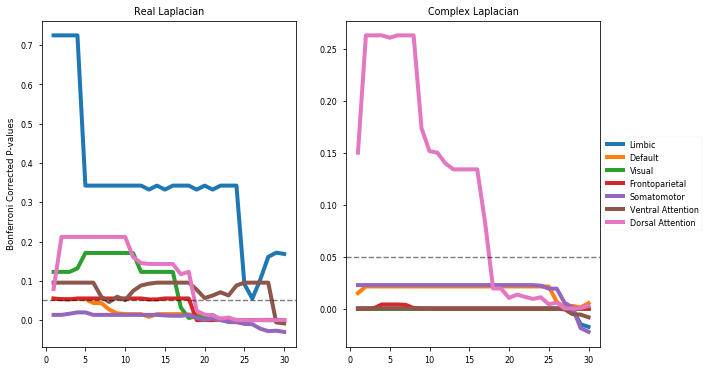

In [91]:
#plot:
eigs = np.arange(1,31)

pfig, (img1, img2) = plt.subplots(ncols = 2, figsize = [10,6])
img1.plot(eigs, np.transpose(reg_pvals), linewidth = LW)
img1.title.set_text('Real Laplacian')
img1.axhline(y = 0.05, alpha = 0.5, color = 'black', ls = '--')
img2.plot(eigs, np.transpose(com_pvals), linewidth = LW)
img2.axhline(y = 0.05, alpha = 0.5, color = 'black', ls = '--')
img2.title.set_text('Complex Laplacian')

plt.legend(ntwk_names, loc = 'center left', bbox_to_anchor = (1, 0.5))
pfig.add_subplot(1,1,1, frameon = False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.ylabel('Bonferroni Corrected P-values')
plt.savefig('figures/fig6/nullpvalues.png', dpi = 300, bbox_inches = 'tight')

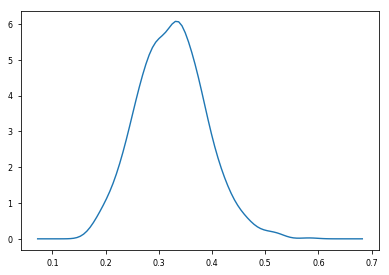

In [50]:
e = stat_dist[0,:]
x = np.linspace(e.min()-0.1, e.max()+0.1, 100)
gkde = scipy.stats.gaussian_kde(dataset = e)
plt.plot(x,gkde.evaluate(x))

In [51]:
gkde.integrate_box_1d(0.64, 1)

1.5902647358034818e-07